<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/deepest_dive_into_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [230]:
import io
import base64
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from IPython.display import HTML

In [231]:
def euclidean_loop_audio(k=5, n=16, bpm=120, bars=4, sr=44100):
    import numpy as np

    # Correct Bjorklund / Euclidean rhythm
    def euclidean_rhythm(k, n):
        if k == 0: return [0]*n
        if k == n: return [1]*n

        groups = [[1] for _ in range(k)] + [[0] for _ in range(n - k)]

        while True:
            l = len(groups)
            if l <= 1: break

            # find how many pairs to merge
            count = min(len([g for g in groups if g == [1]]), len([g for g in groups if g == [0]]))
            if count == 0: break

            new_groups = []
            for i in range(count):
                new_groups.append(groups[i] + groups[-(i+1)])
            # keep the middle untouched if odd
            if 2*count < l:
                new_groups += groups[count:-count]
            groups = new_groups

        return [x for g in groups for x in g]

    # Generate Euclidean pattern
    pattern = euclidean_rhythm(k, n)

    # Step duration in samples
    step_time = 60 / bpm / 4
    step_samples = int(step_time * sr)

    # Generate single pulse
    def pulse(sr=44100, duration=0.01, freq=100):
        t = np.linspace(0, duration, int(sr*duration), False)
        p = np.sin(2*np.pi*freq*t) * np.exp(-60*t)
        return t, p

    t, click = pulse(sr)

    # Make sure pulse fits in step
    if len(click) > step_samples:
        click = click[:step_samples]

    # Fill the bar with pulses
    bar = np.zeros(step_samples * n)
    for i, step in enumerate(pattern):
        if step:
            bar[i*step_samples:i*step_samples+len(click)] += click

    # Tile for bars
    audio = np.tile(bar, bars)
    audio /= np.max(np.abs(audio))
    return audio



def play_with_waveform_loop(audio, sr=44100, width=800, height=200):
    audio = audio / np.max(np.abs(audio))

    # Encode WAV for browser
    buf = io.BytesIO()
    wavfile.write(buf, sr, (audio*32767).astype(np.int16))
    b64 = base64.b64encode(buf.getvalue()).decode()

    # Downsample waveform with MAX pooling for uniform pulse heights
    step = max(1, len(audio)//width)
    samples = [float(np.max(np.abs(audio[i:i+step]))) for i in range(0, len(audio), step)]
    waveform = ",".join(f"{s:.4f}" for s in samples)

    return HTML(f"""
    <div>
      <canvas id="wave" width="{width}" height="{height}"></canvas><br>
      <audio id="audio" controls autoplay loop>
        <source src="data:audio/wav;base64,{b64}" type="audio/wav">
      </audio>
    </div>

    <script>
    const canvas = document.getElementById("wave");
    const ctx = canvas.getContext("2d");
    const audio = document.getElementById("audio");

    const waveform = [{waveform}];
    const mid = canvas.height/2;

    function drawWaveform() {{
        ctx.clearRect(0,0,canvas.width,canvas.height);
        ctx.beginPath();
        ctx.moveTo(0, mid);
        for (let i=0; i<waveform.length; i++) {{
            const x = i*canvas.width/waveform.length;
            const y = mid - waveform[i]*mid*0.9;
            ctx.lineTo(x,y);
        }}
        ctx.strokeStyle = "#444";
        ctx.stroke();
    }}

    function drawPlayhead() {{
        drawWaveform();
        const x = (audio.currentTime % audio.duration)/audio.duration*canvas.width;
        ctx.beginPath();
        ctx.moveTo(x,0);
        ctx.lineTo(x,canvas.height);
        ctx.strokeStyle="red";
        ctx.lineWidth=2;
        ctx.stroke();
        requestAnimationFrame(drawPlayhead);
    }}

    audio.onplay = () => requestAnimationFrame(drawPlayhead);
    drawWaveform();
    </script>
    """)


def play_with_waveform_interface(audios, sr=44100, width=400, height=50):
    """
    Plays one or multiple audio tracks with waveform + play/pause interface.
    - Max-pooled waveform
    - Red playhead
    - Autoplay on cell execution
    - Play/pause via <audio> control
    - Stacked vertically for multiple tracks
    """
    if not isinstance(audios, list):
        audios = [audios]

    # Encode all audios
    wav_datas = []
    for audio in audios:
        audio = audio / max(1e-12, np.max(np.abs(audio)))
        buf = io.BytesIO()
        wavfile.write(buf, sr, (audio*32767).astype(np.int16))
        b64 = base64.b64encode(buf.getvalue()).decode()
        wav_datas.append(b64)

    html_tracks = ""
    for idx, b64 in enumerate(wav_datas):
        html_tracks += f"""
<div style="margin-bottom:10px;">
  <canvas id="wave{idx}" width="{width}" height="{height}" style="border:1px solid #ccc;"></canvas><br>
  <audio id="audio{idx}" controls autoplay loop>
    <source src="data:audio/wav;base64,{b64}" type="audio/wav">
  </audio>
</div>
"""

    # JavaScript to draw waveforms + playhead per track
    js_draw = "<script>\n"
    for idx, audio in enumerate(audios):
        step = max(1, len(audio)//width)
        samples = [float(np.max(np.abs(audio[i:i+step]))) for i in range(0, len(audio), step)]
        js_draw += f"""
const canvas{idx} = document.getElementById("wave{idx}");
const ctx{idx} = canvas{idx}.getContext("2d");
const audio{idx} = document.getElementById("audio{idx}");
const waveform{idx} = [{','.join(f'{s:.4f}' for s in samples)}];
const mid{idx} = canvas{idx}.height/2;

function drawWaveform{idx}() {{
    ctx{idx}.clearRect(0,0,canvas{idx}.width,canvas{idx}.height);
    ctx{idx}.beginPath();
    ctx{idx}.moveTo(0, mid{idx});
    waveform{idx}.forEach((v,i) => {{
        const x = i*canvas{idx}.width/waveform{idx}.length;
        const y = mid{idx} - v*mid{idx}*0.9;
        ctx{idx}.lineTo(x,y);
    }});
    ctx{idx}.strokeStyle = "#444";
    ctx{idx}.stroke();
}}

function drawPlayhead{idx}() {{
    drawWaveform{idx}();
    if (!audio{idx}.paused) {{
        const x = (audio{idx}.currentTime % audio{idx}.duration)/audio{idx}.duration*canvas{idx}.width;
        ctx{idx}.beginPath();
        ctx{idx}.moveTo(x,0);
        ctx{idx}.lineTo(x,canvas{idx}.height);
        ctx{idx}.strokeStyle = "red";
        ctx{idx}.lineWidth = 2;
        ctx{idx}.stroke();
    }}
    requestAnimationFrame(drawPlayhead{idx});
}}

audio{idx}.onplay = () => requestAnimationFrame(drawPlayhead{idx});
drawWaveform{idx}();
"""
    js_draw += "</script>"

    return HTML(html_tracks + js_draw)




In [232]:



def play_with_waveform_interface(audios, sr=44100, width=400, height=50):
    if not isinstance(audios, list):
        audios = [audios]

    # Encode all audios
    wav_datas = []
    for audio in audios:
        audio = audio / max(1e-12, np.max(np.abs(audio)))
        buf = io.BytesIO()
        wavfile.write(buf, sr, (audio*32767).astype(np.int16))
        b64 = base64.b64encode(buf.getvalue()).decode()
        wav_datas.append(b64)

    html_tracks = ""
    for idx, b64 in enumerate(wav_datas):
        html_tracks += f"""
<div style="margin-bottom:10px;">
  <canvas id="wave{idx}" width="{width}" height="{height}" style="border:1px solid #ccc;"></canvas><br>
  <audio id="audio{idx}" controls autoplay loop>
    <source src="data:audio/wav;base64,{b64}" type="audio/wav">
  </audio>
</div>
"""

    js_draw = "<script>\n(function() {\n"
    js_draw += """
    // Clean up previous audio/canvas
    if (!window.currentAudios) window.currentAudios = [];
    if (!window.currentAnimations) window.currentAnimations = [];
    window.currentAudios.forEach(a => a.pause());
    window.currentAnimations.forEach(a => cancelAnimationFrame(a));
    window.currentAudios = [];
    window.currentAnimations = [];
    """

    for idx, audio in enumerate(audios):
        step = max(1, len(audio)//width)
        samples = [float(np.max(np.abs(audio[i:i+step]))) for i in range(0, len(audio), step)]
        js_draw += f"""
const canvas{idx} = document.getElementById("wave{idx}");
const ctx{idx} = canvas{idx}.getContext("2d");
const audio{idx} = document.getElementById("audio{idx}");
window.currentAudios.push(audio{idx});
const waveform{idx} = [{','.join(f'{s:.4f}' for s in samples)}];
const mid{idx} = canvas{idx}.height/2;

function drawWaveform{idx}() {{
    ctx{idx}.clearRect(0,0,canvas{idx}.width,canvas{idx}.height);
    ctx{idx}.beginPath();
    ctx{idx}.moveTo(0, mid{idx});
    waveform{idx}.forEach((v,i) => {{
        const x = i*canvas{idx}.width/waveform{idx}.length;
        const y = mid{idx} - v*mid{idx}*0.9;
        ctx{idx}.lineTo(x,y);
    }});
    ctx{idx}.strokeStyle = "#444";
    ctx{idx}.stroke();
}}

function drawPlayhead{idx}() {{
    drawWaveform{idx}();
    if (!audio{idx}.paused) {{
        const x = (audio{idx}.currentTime % audio{idx}.duration)/audio{idx}.duration*canvas{idx}.width;
        ctx{idx}.beginPath();
        ctx{idx}.moveTo(x,0);
        ctx{idx}.lineTo(x,canvas{idx}.height);
        ctx{idx}.strokeStyle="red";
        ctx{idx}.lineWidth = 2;
        ctx{idx}.stroke();
    }}
    window.currentAnimations.push(requestAnimationFrame(drawPlayhead{idx}));
}}

audio{idx}.onplay = () => requestAnimationFrame(drawPlayhead{idx});
drawWaveform{idx}();
"""
    js_draw += "})();</script>"

    return HTML(html_tracks + js_draw)



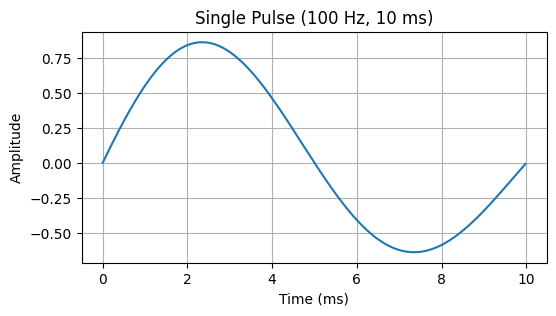

In [233]:


def pulse(sr=44100, duration=0.01, freq=100):
    t = np.linspace(0, duration, int(sr*duration), False)
    p = np.sin(2*np.pi*freq*t) * np.exp(-60*t)
    return t, p

# Generate the pulse
t, p = pulse(sr=44100, duration=0.01, freq=100)

# Plot it
plt.figure(figsize=(6,3))
plt.plot(t*1000, p)  # convert time to milliseconds
plt.title("Single Pulse (100 Hz, 10 ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [234]:
sr = 44100
audio = euclidean_loop_audio(k=2, n=3, bpm=120, bars=4, sr=sr)
play_with_waveform_loop(audio)


In [235]:
sr = 44100

play = []
play.append(euclidean_loop_audio(k=5, n=8, bpm=120, bars=1, sr=sr))
#play.append(euclidean_loop_audio(k=2, n=3, bpm=120, bars=4, sr=sr))
play.append(euclidean_loop_audio(k=16, n=16, bpm=440*2, bars=4, sr=sr))

play_with_waveform_interface(play, sr)


In [204]:


def volume(audio, db=0):
    """Adjust volume in dB"""
    factor = 10**(db / 20)
    return audio * factor


def lowpass(audio, sr=44100, cutoff=1000):
    b, a = butter(2, cutoff / (sr/2), btype='low')
    return lfilter(b, a, audio)

def highpass(audio, sr=44100, cutoff=500):
    b, a = butter(2, cutoff / (sr/2), btype='high')
    return lfilter(b, a, audio)


def echo(audio, sr=44100, delay=0.2, decay=0.5):
    """Add simple echo: delay in seconds, decay factor"""
    n_delay = int(sr * delay)
    output = np.copy(audio)
    for i in range(n_delay, len(audio)):
        output[i] += decay * output[i - n_delay]
    return output / np.max(np.abs(output))  # normalize to avoid clipping

def pan(audio, pan=0.0):
    """Convert mono to stereo with pan (-1 left, 1 right)"""
    left = audio * (1 - pan)/2
    right = audio * (1 + pan)/2
    return np.stack([left, right], axis=1)


def eq(audio, sr=44100, low=None, high=None):
    """Apply optional lowpass/highpass filtering"""
    if low:
        audio = lowpass(audio, sr, low)
    if high:
        audio = highpass(audio, sr, high)
    return audio

def saturate(audio, gain=2.0):
    audio = audio * gain
    audio = np.tanh(audio)  # soft clip
    return audio / np.max(np.abs(audio))



In [211]:
from IPython.display import clear_output

clear_output(wait=True)

In [209]:
sr = 44100
a1 = euclidean_loop_audio(k=1, n=4, bpm=120, bars=4, sr=sr)
a2 = euclidean_loop_audio(k=2, n=3, bpm=120, bars=4, sr=sr)
a3 = euclidean_loop_audio(k=16, n=16, bpm=880, bars=4, sr=sr)

# Apply filters
#a2 = volume(a2, 6)
#a2 = highpass(a2, sr, cutoff=800)
#a2 = echo(a2, sr, delay=0.15, decay=0.4)

play_with_waveform_interface([a1, a2, a3], sr)


# Task
Create an `ipytone` beat with interactive playback controls and a visual representation of the beat pattern in Jupyter.

## Initialize ipytone and prepare drum sounds

### Subtask:
Import necessary `ipytone` components and create `Sampler` instances for different drum sounds (kick, snare, hi-hat) using provided sample URLs.


**Reasoning**:
To initialize `ipytone` and prepare drum sounds as per the subtask, I need to import the required classes (`Sampler`, `Transport`, `Sequence`) and create `Sampler` instances for kick, snare, and hi-hat using the provided URLs.

